## Bayesian parameter estimation using MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import *
from UQpy.RunModel import RunModel # required to run the quadratic model
from sklearn.neighbors import KernelDensity # for the plots
from statsmodels.nonparametric.kde import KDEUnivariate

## Probability model

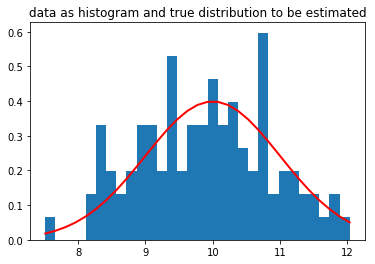

In [2]:
# Generate data from a probability model, here a Gaussian pdf, then learn its parameters, 
# mean and covariance, from this data

np.random.seed(100)
mu, sigma = 10, 1 # true mean and standard deviation
data = np.random.normal(mu, sigma, 100)
np.random.seed()

# plot the data and true distribution
count, bins, ignored = plt.hist(data, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('data as histogram and true distribution to be estimated')
plt.show()

In [3]:
# create an instance of class Model
candidate_model = Model(model_type = 'pdf', model_name='normal', 
                        prior_name = ['uniform','lognormal'], prior_params = [[0, 15], [1, 0, 1]])

In [4]:
# Learn the unknown parameters using MCMC
bayes_estimator = BayesParameterEstimation(data=data, sampling_method = 'MCMC', nsamples=500, 
                                           pdf_proposal = 'Normal', pdf_proposal_scale=[1, 1], model=candidate_model, 
                                           algorithm = 'MH', jump=10, nburn=10, 
                                           seed=np.array([1.0, 0.2]))

Successful execution of the MCMC design


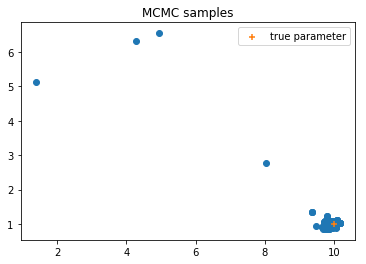

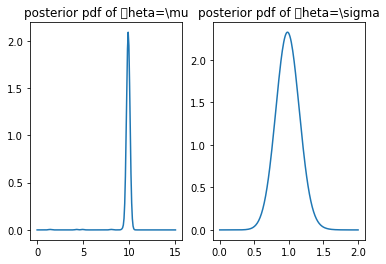

In [5]:
# print results
s = bayes_estimator.samples
plt.scatter(s[:,0],s[:,1])
plt.scatter(10, 1, marker = '+', label='true parameter')
plt.title('MCMC samples')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,2)

domain = np.linspace(0, 15, 200)[:, np.newaxis]
bandwidth = 1.06*np.std(s[:,0])*s[:,0].shape[0]**(-1/5)
kde = KernelDensity(bandwidth=bandwidth).fit(s[:,0].reshape((-1,1)))
log_dens = kde.score_samples(domain)
ax[0].plot(domain, np.exp(log_dens))
ax[0].set_title('posterior pdf of \theta=\mu')

domain = np.linspace(0, 2, 200)[:, np.newaxis]
bandwidth = 1.06*np.std(s[:,0])*s[:,0].shape[0]**(-1/5)
kde = KernelDensity(bandwidth=bandwidth).fit(s[:,1].reshape((-1,1)))
log_dens = kde.score_samples(domain)
ax[1].plot(domain, np.exp(log_dens))
ax[1].set_title('posterior pdf of \theta=\sigma')

plt.show()

## Regression model

In [6]:
# Generate data from a quadratic function
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
z = RunModel(samples=param_true, model_script='pfn_quadratic.py', model_object_name = 'RunPythonModel', 
             var_names = ['theta_1', 'theta_2'])

data = z.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)
[  0.30424259  -0.52629304   1.08238706   1.70515057   2.73941968
   3.63622486   4.17434011   5.52613416   7.85684334   8.79008326
   9.29569257  11.86668825  15.34569786  17.03109086  18.94216978
  22.3142979   25.67808439  27.94913255  29.07685441  32.85029206
  37.88808706  41.67296401  47.02559935  50.1804267   51.83448719
  57.4247519   63.44149602  65.53511979  68.54344139  74.17388908
  81.05787933  84.21746543  91.20864832  97.74283232 102.99510492
 109.61625761 114.39336139 119.01982504 127.80962764 134.72459655
 140.22954769 149.33220533 154.43785426 163.3531736  170.12733269
 178.91600404 185.56870186 195.27908894 200.59835242 208.67915583]


In [7]:
candidate_model = Model(model_type='python', model_script='pfn_quadratic.py', n_params=2, 
                        error_covariance=error_covariance)

In [8]:
bayes_estimator = BayesParameterEstimation(data=data, model=candidate_model, sampling_method = 'MCMC', nsamples=500,
                                           algorithm = 'MH', jump=10, nburn=0, pdf_proposal = 'Normal',
                                           pdf_proposal_scale = [0.1, 0.05], seed = [0.5, 2.5])

Successful execution of the MCMC design


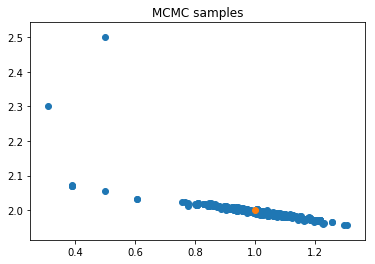

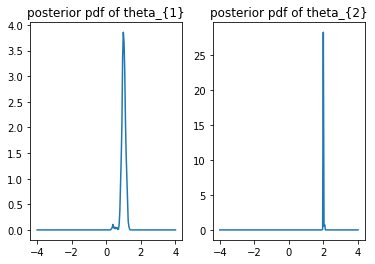

In [9]:
s = bayes_estimator.samples
plt.scatter(s[:,0],s[:,1])
plt.scatter(1.0, 2.0, label='true value')
plt.title('MCMC samples')
plt.show()

fig, ax = plt.subplots(1,2)

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,0])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[0].plot(domain, pdf_, label='prior')
ax[0].set_title('posterior pdf of theta_{1}')

domain = np.linspace(-4, 4, 200)[:, np.newaxis]
kde = KDEUnivariate(s[:,1])
kde.fit(kernel='gau', bw='normal_reference', fft=False, weights=None)
pdf_ = []
for d in domain:
    pdf_.append(kde.evaluate(d))
ax[1].plot(domain, pdf_, label='prior')
ax[1].set_title('posterior pdf of theta_{2}')

plt.show()

Acceptance ratio of the chain = 0.07061412282456492
Multivariate ESS = 4906.780273179653, minESS = 7529.096402175249
Univariate ESS in each dimension
Parameter 1: ESS = 1781.106487575327, minESS = 6146.334113110603
Parameter 2: ESS = 2655.2632652597426, minESS = 6146.334113110603


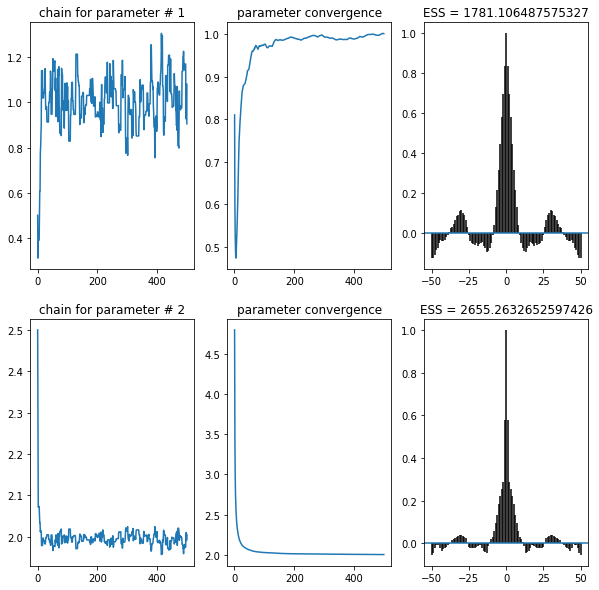

In [10]:
Diagnostics(sampling_method='MCMC', sampling_outputs = bayes_estimator)